In [1]:
import tensorflow as tf
import numpy as np
from network_parts import *
import matplotlib as plt

In [2]:
num_classes = 4

### Architecture

In [3]:
blank = tf.placeholder(tf.float32)

z_vector = tf.Variable(np.zeros(shape=[1, vec_size]), dtype=tf.float32)
target_vector = tf.Variable(np.zeros(shape=[1, num_classes]), dtype=tf.float32)

In [4]:
decoded = decoder(z_vector)

In [23]:
with tf.variable_scope('convolution'):
    classifier = convolution(decoded)

In [19]:
probs = tf.nn.softmax(classifier)

In [20]:
loss = tf.reduce_mean(-tf.reduce_sum(target_vector * tf.log(probs), reduction_indices=[1]))

In [21]:
optim = tf.train.AdamOptimizer().minimize(loss, var_list=[z_vector])

### Utils

In [22]:
sess = tf.InteractiveSession()

In [47]:
any(map(lambda x: x in tf.global_variables()[0].name , ['first_dense', 'second_dense']))

True

In [59]:
vae_weights = list(filter(lambda x: any(map(lambda y: y in x.name, ['first_dense', 'second_dense', 'third_dense', 'output'])), tf.global_variables()))

In [60]:
classifier_weights = list(filter(lambda x: 'convolution' in x.name, tf.global_variables()))

In [61]:
tf.train.Saver(classifier_weights).restore(sess, 'weights/classifier_0')
tf.train.Saver(vae_weights).restore(sess, 'weights/VAE_2')

INFO:tensorflow:Restoring parameters from weights/classifier_0
INFO:tensorflow:Restoring parameters from weights/VAE_2


### Optimization

In [66]:
sess.run(tf.global_variables_initializer())

In [123]:
asignment_z = z_vector.assign(np.array([np.random.uniform(-10, 100, vec_size)]))
asignment_y = target_vector.assign([[0.2, 0.3, 0.2, 0.3]])

sess.run(asignment_z)
sess.run(asignment_y)

array([[ 0.2       ,  0.30000001,  0.2       ,  0.30000001]], dtype=float32)

In [124]:
for i in range(1000):
    _, l = sess.run([optim, loss], feed_dict={blank: 1})
    print(l)

26.46
26.4574
26.4532
26.4479
26.442
26.4351
26.4279
26.4207
26.4128
26.4044
26.3964
26.3882
26.3797
26.3712
26.3627
26.3544
26.3459
26.3372
26.3289
26.3204
26.3123
26.3041
26.2958
26.2879
26.2799
26.272
26.2644
26.2568
26.2494
26.2419
26.2346
26.2273
26.2197
26.2125
26.205
26.1979
26.1908
26.1837
26.1767
26.1696
26.1626
26.1558
26.1492
26.1423
26.1356
26.1288
26.1224
26.1158
26.1094
26.1032
26.0972
26.0909
26.0848
26.0788
26.0726
26.0668
26.0609
26.0551
26.0495
26.0439
26.0384
26.0329
26.0275
26.0221
26.0169
26.0118
26.0067
26.0016
25.9966
25.9915
25.9863
25.9813
25.9764
25.9714
25.9663
25.9614
25.9566
25.9515
25.9467
25.9419
25.9368
25.932
25.9271
25.9222
25.9176
25.9128
25.908
25.9033
25.8986
25.894
25.8893
25.8847
25.8799
25.8752
25.8707
25.8661
25.8615
25.8573
25.8526
25.848
25.8437
25.8391
25.8347
25.8299
25.8255
25.821
25.8164
25.8118
25.8073
25.8028
25.7983
25.7938
25.7894
25.785
25.7805
25.7762
25.7719
25.7676
25.7631
25.7589
25.7545
25.7501
25.7457
25.7412
25.7368
25.7324
25.

In [101]:
sess.run(z_vector)

array([[ 1.12170494,  0.93853378,  0.90683681,  1.15132844,  1.0440259 ,
         0.97129929,  1.04377985,  1.10456705,  0.87491149,  1.10148442,
         1.01827419,  0.9114905 ,  0.90995693,  1.01402998,  0.90282238,
         0.93466306,  0.93600643,  0.89093572,  0.90092158,  1.0897032 ,
         1.07369673,  0.83836025,  0.87696791,  0.92298228,  0.92156303,
         0.90167576,  0.96381468,  1.07905102,  1.01282501,  0.83833456,
         0.87733978,  0.88860923,  0.95257115,  1.13952768,  0.89702123,
         0.90294009,  1.01245737,  0.96476454,  0.83087289,  1.16894531,
         0.89796257,  0.96463227,  0.85930562,  0.96920216,  1.03292763,
         1.02528465,  1.10538006,  1.15852153,  1.05444729,  0.95037216,
         1.12576604,  1.16672146,  0.93856299,  0.86496341,  1.03977847,
         1.04247773,  1.07123744,  0.95302314,  1.1477679 ,  1.09961379,
         0.91365963,  1.12526715,  0.86148417,  1.01035595,  1.03635931,
         0.89932013,  0.99007016,  0.90954089,  0.9

In [104]:
a = sess.run(decoded, feed_dict={blank: 1})

In [113]:
from PIL import Image

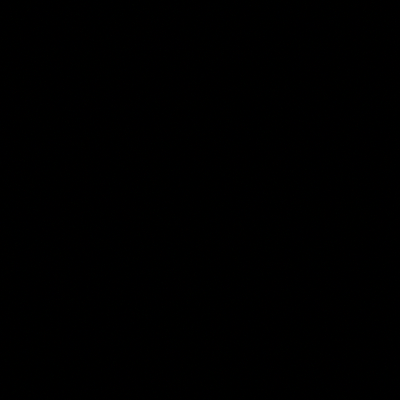

In [115]:
Image.fromarray(a.astype(np.uint8)[0])